# Read the observation data from file

In [61]:
import numpy as np
import pandas as pd

lc = np.genfromtxt("data/PG1302_CRTS.dat", names="mjd, mag, magerr", delimiter=",", skip_header=1)
#print(str(lc['mag']))

# Plot the observed signal

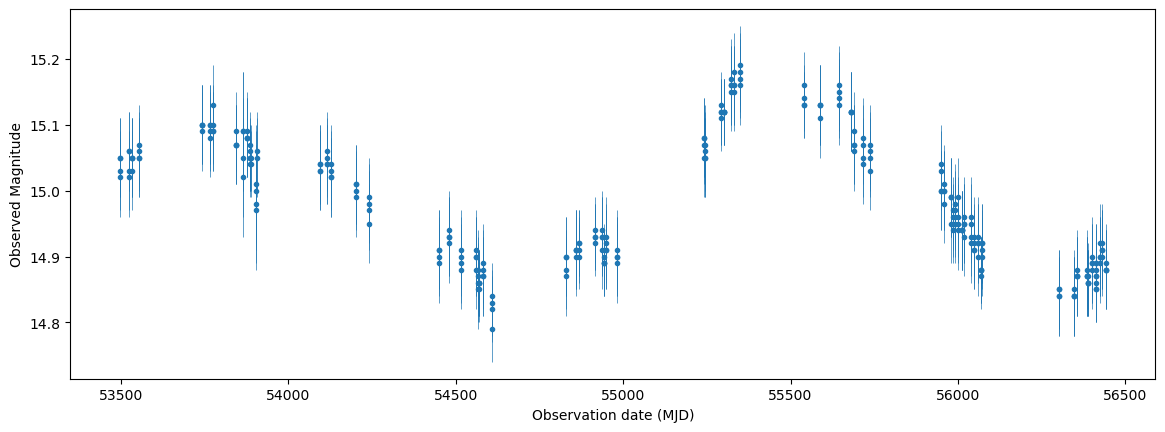

                mjd         mag      magerr
count    290.000000  290.000000  290.000000
mean   55133.381769   14.982724    0.058897
std      940.406959    0.096498    0.006563
min    53496.204980   14.790000    0.050000
25%    54241.260252   14.900000    0.060000
50%    55245.416825   14.960000    0.060000
75%    56000.460690   15.060000    0.060000
max    56442.175330   15.190000    0.090000


In [63]:
import matplotlib.pyplot as plt

t = lc["mjd"] 
mag = lc["mag"] 
magerr = lc['magerr']

plt.figure().set_figwidth(14)
plt.xlabel("Observation date (MJD)")
plt.ylabel("Observed Magnitude")
#plt.plot(t, mag, marker='None', linestyle='-', zorder=1, lw=1)
plt.errorbar(t, mag, yerr=magerr, fmt=".", zorder=0, lw=0.5)
plt.savefig('output/PG1302-observed-lightcurve.png', bbox_inches="tight")
plt.show()
print(pd.DataFrame(lc.flatten()).describe())


# Method to aggregate data into bins of "n" days. This is not used.

In [65]:
from scipy.stats import binned_statistic

# Use binned_statistic to calculate mean within each bin
def get_binned_statistic(num_bins, t, mag, magerr):
    bin_mag, bin_edges, binnumber = binned_statistic(t, mag, statistic=np.nanmean, bins=num_bins)
    bin_magerr, bin_edges, binnumber = binned_statistic(t, magerr, statistic=np.nanmean, bins=num_bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_t = bin_edges[1:] - bin_width/2

    filter = np.isfinite(bin_mag)
    #print(str(filter[:10]))
    bin_mag = bin_mag[filter]
    bin_t = bin_t[filter]
    bin_magerr = bin_magerr[filter]
    return (bin_t, bin_mag, bin_magerr)
    
#plt.scatter(bin_t, bin_mag)
#plt.show()

# Create the Lomb Scargle Periodogram 
## Method 1: Using PyAstronomy.pyTiming.pyPeriod.Gls (Generalized Lomb-Scargle Periodogram)

In [67]:
from PyAstronomy.pyTiming import pyPeriod
import scipy.signal as sig 
import pandas as pd
import time

#Total 2946 days of observation -> max period ~3000d. 
# We consider min period as 30d
# Create 3000 frequency buckets (~1 per day of observation)
freqs = np.linspace(1/3000, 1/30,num=3000) 

# Perform analysis
# Compute the GLS periodogram with default options.
freqs = np.linspace(1/3000, 1/30,num=3000) 
start_time = time.time()
clp = pyPeriod.Gls((t, mag, magerr), freq=freqs)
print('Execution time: {0:.2f}'.format(time.time() - start_time))
#powers = ls.power(freqs)

# Print helpful information to screen
clp.info()

# Find the frequencies with the strongest signal
# get the max power
max_power = np.max(clp.power)
#print('max_power={0:.4f}'.format(max_power))
#print(pd.DataFrame(clp.power.flatten()).describe())
top_ind, _ = sig.find_peaks(clp.power, max_power/4.0)

# Define FAP levels of 10%, 5%, and 1%
fapLevels = np.array([0.1, 0.05, 0.01])
# Obtain the associated power thresholds
plevels = clp.powerLevel(fapLevels)
#print("plevels=" + str(plevels))
## Print the info of top signals
for j, k in enumerate(top_ind):
    print('## {0}th strongest signal: {1:.4f}'.format(j+1, clp.power[k]))
    print('at freq(1/d):     {0:.4f}'.format(clp.freq[k]))
    print('at period(d):     {0:.0f}d'.format(1/clp.freq[k]))
    print('FAP:              {0:.1e}'.format(clp.FAP(clp.power[k])))



Execution time: 0.05
Generalized LS - statistical output
-----------------------------------
Number of input points:      290   
Weighted mean of dataset:    14.980352
Weighted rms of dataset:     0.097948
Time base:                   2945.970350
Number of frequency points:  3000  

Maximum power p [ZK]:  0.896140
RMS of residuals:      0.031566
  Mean weighted internal error:  0.058014
Best sine frequency:   0.000586 +/-  0.000007
Best sine period:      1705.269143 +/-  20.689008
Amplitude:             0.124464 +/-  0.002621
Phase (ph):            0.082196 +/-  0.003352
Phase (T0):            53356.037895 +/-  5.716148
Offset:                14.989313 +/-  0.001854
-----------------------------------
## 1th strongest signal: 0.8961
at freq(1/d):     0.0006
at period(d):     1705d
FAP:              7.0e-140
## 2th strongest signal: 0.3530
at freq(1/d):     0.0021
at period(d):     465d
FAP:              7.1e-26
## 3th strongest signal: 0.5237
at freq(1/d):     0.0033
at period(d):     

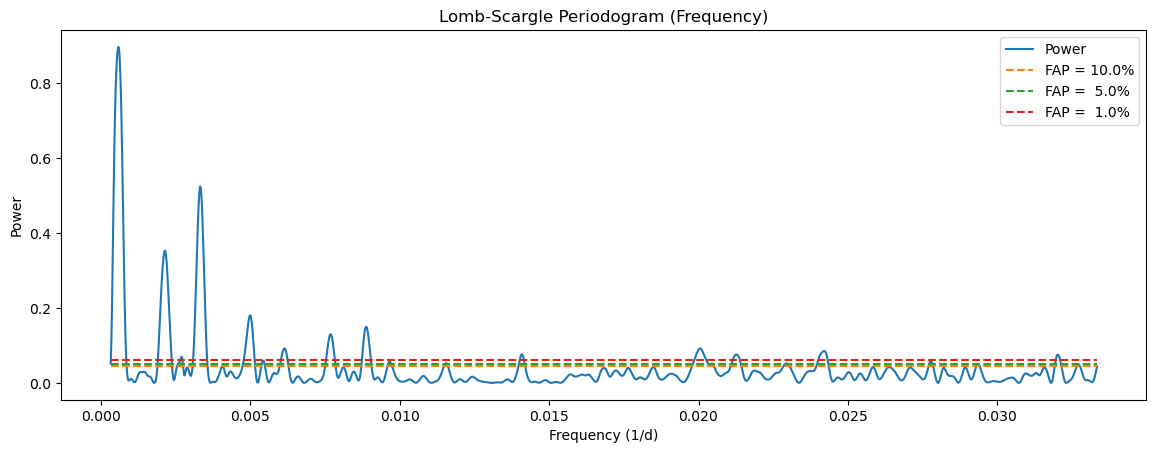

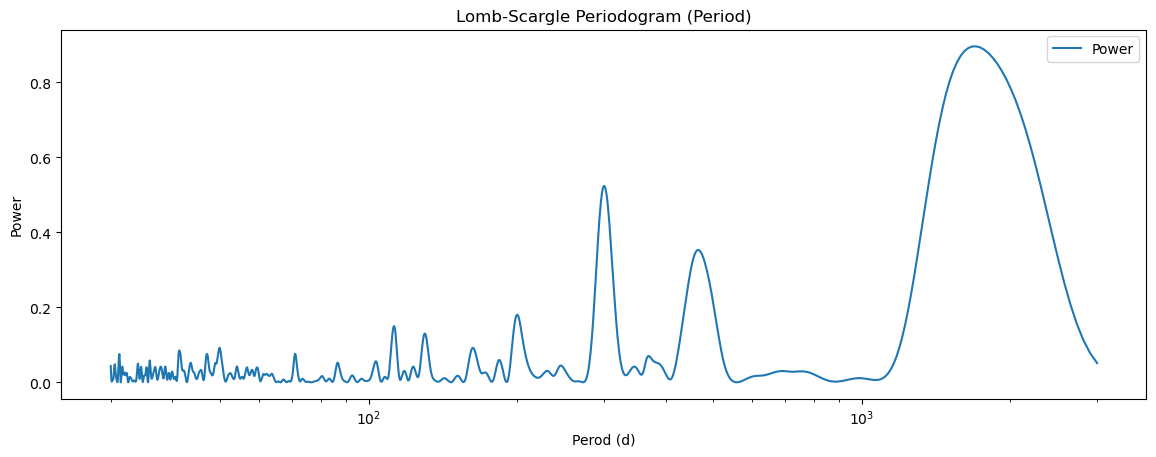

In [68]:
plt.figure().set_figwidth(14)
plt.xlabel("Frequency (1/d)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram (Frequency)")
plt.savefig('output/PG1302-ls-periodogram-freq.png', bbox_inches="tight")
plt.plot(clp.freq, clp.power, label="Power")

# Add the FAP levels to the plot
for i in range(len(fapLevels)):
    plt.plot([min(clp.freq), max(clp.freq)], [plevels[i]]*2, '--',
             label="FAP = %4.1f%%" % (fapLevels[i]*100))
plt.legend()
plt.show()

plt.figure().set_figwidth(14)
plt.xlabel("Perod (d)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram (Period)")
plt.plot(1.0/clp.freq, clp.power, label="Power")
plt.xscale("log")

plt.legend()
plt.savefig('output/PG1302-ls-periodogram-period.png', bbox_inches="tight")
plt.show()


## Method 2: Using astropy.timeseries.LombScargle (Lomb-Scargle Periodogram)

## 1th strongest signal: 0.8836
at freq(1/d):     0.0006
at period(d):     1701d
FAP:              2.6e-130
## 2th strongest signal: 0.3510
at freq(1/d):     0.0021
at period(d):     467d
FAP:              8.3e-24
## 3th strongest signal: 0.5142
at freq(1/d):     0.0033
at period(d):     301d
FAP:              1.0e-41


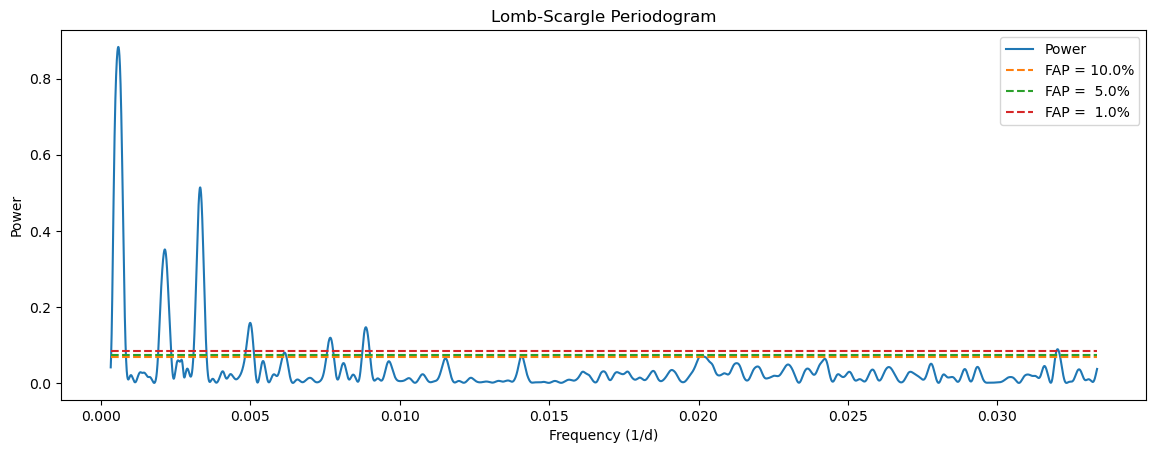

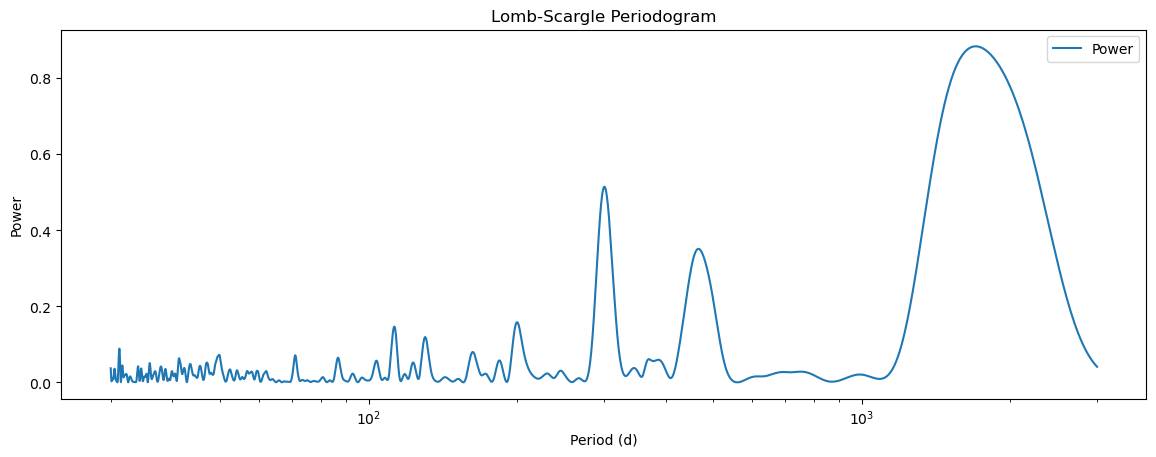

In [70]:
from astropy.timeseries import LombScargle
import scipy.signal as sig 

#Total 2946 days of observation -> max period ~3000d. 
# We consider min period as 30d
# Create 3000 frequency buckets (~1 per day of observation)
# freqs = np.linspace(1/3000, 1/30,num=3000) 

# Perform analysis
ls = LombScargle(t , mag)
freqs, powers = ls.autopower(minimum_frequency=1.0/3000, maximum_frequency=1.0/30, samples_per_peak=100)

# Find the frequencies with the strongest signal
top_ind, _ = sig.find_peaks(powers, height=np.max(powers)/4)
#k = np.unravel_index(np.argmax(powers), powers.shape)
#print(str(top3ind))    
for j, k in enumerate(top_ind):
    print('## {0}th strongest signal: {1:.4f}'.format(j+1, powers[k]))
    print('at freq(1/d):     {0:.4f}'.format(freqs[k]))
    print('at period(d):     {0:.0f}d'.format(1/freqs[k]))
    print('FAP:              {0:.1e}'.format(ls.false_alarm_probability(powers[k])))

# Define FAP levels of 10%, 5%, and 1%
fapLevels = np.array([0.1, 0.05, 0.01])
# Obtain the associated power thresholds
plevels = ls.false_alarm_level(fapLevels)

## Plot the periodogram with Frequency on X-axis
plt.figure().set_figwidth(14)
plt.xlabel("Frequency (1/d)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.plot(freqs, powers, label="Power")
# Add the FAP levels to the plot
for i in range(len(fapLevels)):
    plt.plot([min(freqs), max(freqs)], [plevels[i]]*2, '--',
             label="FAP = %4.1f%%" % (fapLevels[i]*100))
plt.legend()

plt.savefig('output/PG1302-ls-periodogram-freq.png', bbox_inches="tight")
plt.show()

## Plot the periodogram with Period on X-axis
plt.figure().set_figwidth(14)
plt.xlabel("Period (d)")
plt.xscale("log")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")
plt.plot(1.0/freqs, powers, label="Power")
plt.legend()

plt.savefig('output/PG1302-ls-periodogram-period.png')
plt.show()
# TODO: Find the FAP (False probability)

# Plot the top3 sinusoidal frequencies along with the observed signal

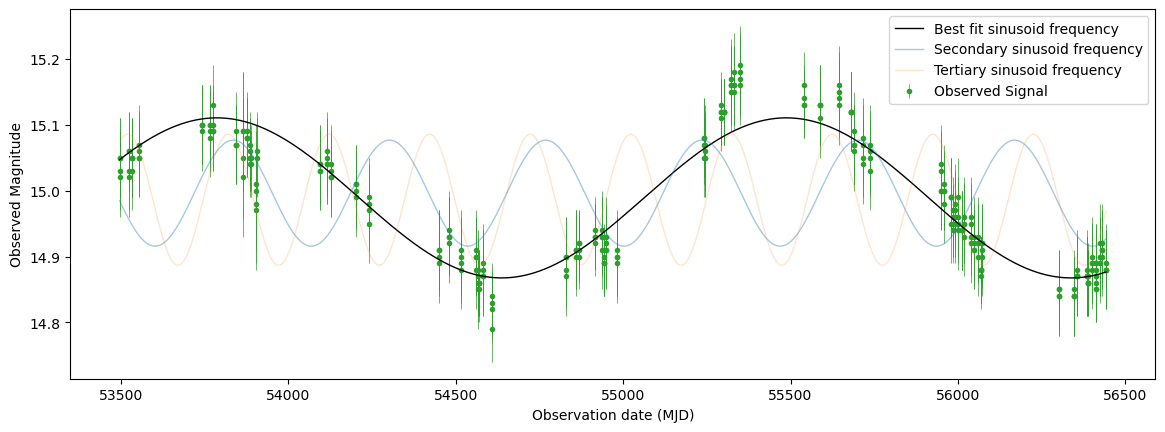

In [72]:
plt.figure().set_figwidth(14)
plt.xlabel("Observation date (MJD)")
plt.ylabel("Observed Magnitude")

t_fit = np.linspace(np.min(t), np.max(t), num=1000)
y1_fit = ls.model(t_fit, freqs[top_ind[0]])
plt.plot(t_fit, y1_fit, marker='None', linestyle='-', color='black', zorder=1, lw=1, label="Best fit sinusoid frequency")
## This model cannot fit to multiple frequencies, so we are fitting 3 frequencies independently. 
## The amplitudes for second and third frequency are not derived correctly this way 
y2_fit = ls.model(t_fit, freqs[top_ind[1]])
plt.plot(t_fit, y2_fit, marker='None', linestyle='-', zorder=1, lw=1, alpha=0.4, label="Secondary sinusoid frequency")
y3_fit = ls.model(t_fit, freqs[top_ind[2]])
plt.plot(t_fit, y3_fit, marker='None', linestyle='-', zorder=1, lw=1, alpha=0.2, label="Tertiary sinusoid frequency")
plt.errorbar(t, mag, yerr=magerr, fmt=".", lw=.5, zorder=0, label="Observed Signal")
plt.legend()

plt.savefig('output/PG1302-ls-periodogram-fittedmodel.png', bbox_inches="tight")
plt.show()